___

<a href='https://sites.google.com/fat.uerj.br/livia'> <img src='../../figures/capa2.png' /></a>
___

In [1]:
path_data = '../../data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# O Bootstrap
Um cientista de dados está usando os dados em uma amostra aleatória para estimar um parâmetro desconhecido. Ela usa a amostra para calcular o valor de uma estatística que usará como estimativa.

Depois de calcular o valor observado de sua estatística, ela poderia apenas apresentá-lo como sua estimativa e seguir seu caminho alegre. Mas ela é uma cientista de dados. Ela sabe que sua amostra aleatória é apenas uma das inúmeras amostras aleatórias possíveis e, portanto, sua estimativa é apenas uma das inúmeras estimativas plausíveis.

Em quanto essas estimativas poderiam variar? Para responder a isso, parece que ela precisa extrair outra amostra da população e calcular uma nova estimativa com base na nova amostra. Mas ela não tem recursos para voltar à população e colher outra amostra.

Parece que o cientista de dados está travado.

Felizmente, uma ideia brilhante chamada *o bootstrap* pode ajudá-la. Como não é viável gerar novas amostras da população, o bootstrap gera novas amostras aleatórias por um método chamado *resampling*: as novas amostras são retiradas aleatoriamente *da amostra original*.

Nesta seção, veremos como e por que o bootstrap funciona. No restante do capítulo, usaremos o bootstrap para inferência.

## Remuneração de Empregados na Cidade de São Francisco
[SF OpenData](https://data.sfgov.org) é um site onde a cidade e o condado de São Francisco disponibilizam alguns de seus dados ao público. Um dos conjuntos de dados contém dados de remuneração para funcionários da cidade. Isso inclui profissionais médicos em hospitais administrados pela cidade, policiais, bombeiros, trabalhadores de transporte, funcionários eleitos e todos os outros funcionários da cidade.

Os dados de remuneração para o ano civil de 2019 estão na tabela `sf2019`.

In [2]:
sf2019 = pd.read_csv(path_data + 'san_francisco_2019.csv')

In [3]:
sf2019.head()

,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
0,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332.0,0.0,40059.0,131391.0
1,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241.0,0.0,49279.0,172520.0
2,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715.0,0.0,46752.0,162468.0
3,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,159394.0,0.0,57312.0,216706.0
4,Public Protection,Adult Probation,Information Systems,IS Programmer Analyst,70035.0,0.0,28671.0,98706.0


Há uma linha para cada um dos mais de 44.500 funcionários. Existem inúmeras colunas contendo informações sobre a afiliação departamental da cidade e detalhes das diferentes partes do pacote de remuneração do funcionário. Aqui está a linha correspondente ao London Breed, prefeito de San Francisco em 2019.

In [4]:
sf2019[sf2019['Job']=='Mayor']

,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
43382,General Administration & Finance,Mayor,Administrative & Mgmt (Unrep),Mayor,342974.0,0.0,98012.0,440987.0


Vamos estudar a coluna final, `Total Compensation`. Esse é o salário do funcionário mais a contribuição da cidade para seus planos de aposentadoria e benefícios.

Às vezes, os pacotes financeiros em um ano civil podem ser difíceis de entender, pois dependem da data de contratação, se o funcionário está mudando de emprego na cidade e assim por diante. Por exemplo, os valores mais baixos na coluna `Total Compensation` parecem um pouco estranhos.

In [5]:
sf2019.sort_values('Total Compensation').head(10)

,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
18526,"Public Works, Transportation & Commerce",Municipal Transportation Agcy,"Clerical, Secretarial & Steno",Senior Clerk Typist,0.0,0.0,0.0,0.0
43234,General Administration & Finance,Human Resources,Public Service Aide,Public Service Trainee,0.0,0.0,0.0,0.0
22329,"Public Works, Transportation & Commerce",Public Utilities Commission,"Clerical, Secretarial & Steno",Senior Clerk,0.0,0.0,0.0,0.0
32865,Community Health,Public Health,Public Service Aide,PS Aide Health Services,0.0,0.0,0.0,0.0
38732,Culture & Recreation,Recreation And Park Commission,Recreation,Pool Lifeguard,0.0,0.0,0.0,0.0
40786,General Administration & Finance,Administrative Services,Journeyman Trade,Automotive Machinist,0.0,0.0,0.0,0.0
38974,Culture & Recreation,Recreation And Park Commission,Recreation,Camp Assistant,0.0,0.0,0.0,0.0
40788,General Administration & Finance,Administrative Services,Journeyman Trade,Automotive Machinist,0.0,0.0,0.0,0.0
10644,"Public Works, Transportation & Commerce",Building Inspection,"Clerical, Secretarial & Steno",Principal Clerk,0.0,0.0,0.0,0.0
3606,Public Protection,Juvenile Court,Correction & Detention,"Counselor, Juvenile Hall PERS",0.0,0.0,0.0,0.0


Para clareza de interpretação, focaremos nossa atenção naqueles que tiveram aproximadamente o equivalente a um emprego de meio período ou mais durante todo o ano. Com um salário mínimo de cerca de 15 dólares por hora e 20 horas por semana durante 52 semanas, isso representa um salário de mais de 15.000 dólares.

In [6]:
sf2019 = sf2019[sf2019['Salary'] > 15000]

In [7]:
sf2019.shape

(37103, 8)

## População e Parâmetro
Deixe esta tabela de pouco mais de 37.000 linhas ser nossa população. Aqui está um histograma das remunerações totais para os funcionários nesta tabela.

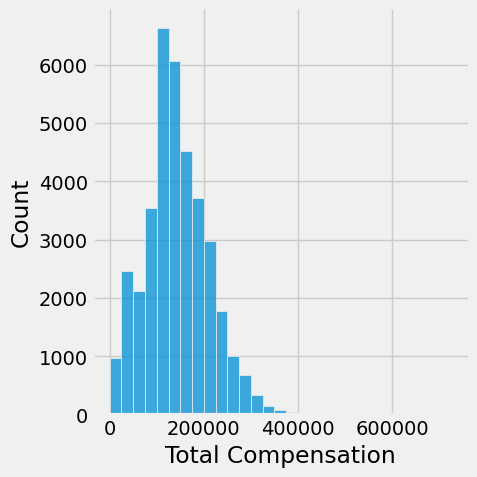

In [8]:
sf_bins = np.arange(0, 726000, 25000)
sns.displot(sf2019['Total Compensation'], bins=sf_bins, kde=False);


Embora a maioria dos valores esteja abaixo de 300.000 dólares, alguns são um pouco mais altos. Por exemplo, a remuneração total do Diretor de Investimentos foi de mais de 700.000 dólares. É por isso que o eixo horizontal se estende bem para a direita das barras visíveis.

In [9]:
sf2019.sort_values('Total Compensation', ascending=False).head()

,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
43936,General Administration & Finance,Retirement Services,Administrative & Mgmt (Unrep),Chief Investment Officer,577633.0,0.0,146398.0,724031.0
43937,General Administration & Finance,Retirement Services,Unassigned,Managing Director,483072.0,0.0,134879.0,617951.0
43938,General Administration & Finance,Retirement Services,Unassigned,Managing Director,482649.0,0.0,134905.0,617554.0
43940,General Administration & Finance,Retirement Services,Unassigned,Managing Director,451507.0,0.0,120276.0,571784.0
43939,General Administration & Finance,Retirement Services,Unassigned,Managing Director,449378.0,0.0,120857.0,570235.0


Suponha que o parâmetro em que estamos interessados seja a mediana das compensações totais.

Como temos o luxo de ter todos os dados da população, podemos simplesmente calcular o parâmetro:

In [10]:
pop_median = np.percentile(sf2019['Total Compensation'], 50, method='nearest')
pop_median

135747.0

A remuneração média total de todos os funcionários foi de 135.747 dólares.

Do ponto de vista prático, não há razão para desenharmos uma amostra para estimar esse parâmetro, pois simplesmente conhecemos seu valor. Mas nesta seção vamos fingir que não sabemos o valor e ver o quão bem podemos estimá-lo com base em uma amostra aleatória.

Nas seções posteriores, vamos colocar os pés no chão e trabalhar em situações em que o parâmetro é desconhecido. Por enquanto, somos oniscientes.

## Uma amostra aleatória e uma estimativa
Vamos desenhar uma amostra de 500 funcionários aleatoriamente, sem reposição, e deixar que a remuneração total mediana dos funcionários da amostra sirva como nossa estimativa do parâmetro.

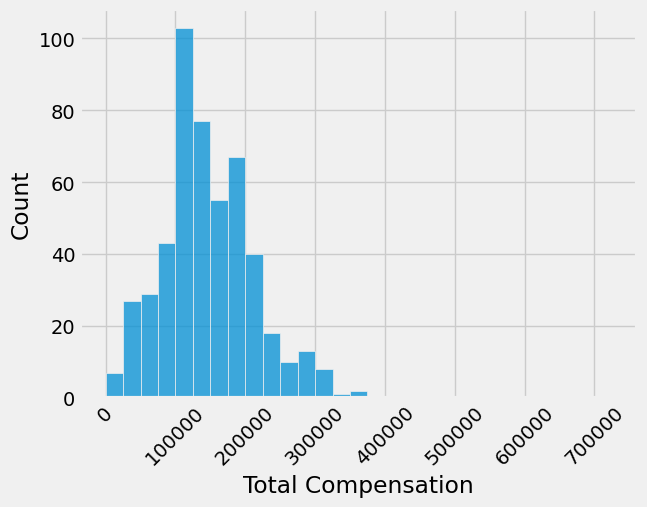

In [11]:
our_sample = sf2019.sample(n=500, replace=False)
#sns.displot(our_sample['Total Compensation'], bins=sf_bins, kde=True)
sns.histplot(our_sample['Total Compensation'], bins=sf_bins);
plt.xticks(rotation=45);

In [12]:
est_median = np.percentile(our_sample['Total Compensation'], 50, method='nearest')
est_median

136625.0

O tamanho da amostra é grande. Pela lei das médias, a distribuição da amostra se assemelha à da população. Consequentemente, a mediana da amostra é bastante comparável à mediana da população, embora obviamente não seja exatamente a mesma.

Portanto, agora temos uma estimativa do parâmetro. Mas se a amostra tivesse resultado diferente, a estimativa teria um valor diferente. Gostaríamos de ser capazes de quantificar a quantidade pela qual a estimativa pode variar entre as amostras. Essa medida de variabilidade nos ajudará a medir com que precisão podemos estimar o parâmetro.

Para ver quão diferente seria a estimativa se a amostra tivesse um resultado diferente, poderíamos simplesmente extrair outra amostra da população. Mas isso seria trapaça. Estamos tentando imitar a vida real, na qual não teremos todos os dados populacionais em mãos.

De alguma forma, temos que obter outra amostra aleatória *sem amostrar novamente da população*.

## O Bootstrap: Reamostragem a partir da Amostra

O que temos é uma grande amostra aleatória da população. Como sabemos, uma grande amostra aleatória provavelmente se assemelhará à população da qual foi extraída. Essa observação permite que os cientistas de dados se *elevem por conta própria*: o procedimento de amostragem pode ser replicado por *amostragem da amostra*.

Aqui estão as etapas do *método bootstrap* para gerar outra amostra aleatória que se assemelha à população:

- **Trate a amostra original como se fosse a população.**
- **Tirar da amostra, aleatoriamente com reposição, o mesmo número de vezes que o tamanho da amostra original**.

É importante reamostrar o mesmo número de vezes que o tamanho da amostra original. A razão é que a variabilidade de uma estimativa depende do tamanho da amostra. Como nossa amostra original consistia em 500 funcionários, nossa mediana amostral foi baseada em 500 valores. Para ver o quão diferente a amostra poderia ter sido, temos que compará-la com a mediana de outras amostras de tamanho 500.

Se extraíssemos 500 vezes aleatoriamente *sem* reposição de nossa amostra de tamanho 500, obteríamos apenas a mesma amostra de volta. Ao sortear *com* reposição, criamos a possibilidade das novas amostras serem diferentes da original, pois alguns funcionários podem ser sorteados mais de uma vez e outros não.

## Por que o Bootstrap funciona

Por que isso é uma boa ideia? Pela lei das médias, a distribuição da amostra original provavelmente se assemelhará à população, e as distribuições de todas as "reamostras" provavelmente se assemelharão à amostra original. Portanto, é provável que as distribuições de todas as reamostras também se assemelhem à população.

!['bootstrap'](../../figures/bootstrap_pic.png)

## Uma mediana reamostrada
Lembre-se que usando o método `sample` do pacote `pándas` podemos tirar linhas de uma tabela e alem disso é possivel falar para ele que substituir as linhas retiradas. Isso é perfeito para o bootstrap! Aqui está uma nova amostra extraída da amostra original e a mediana da amostra correspondente.

In [13]:
resample_1 = our_sample.sample(replace=True, n=500)

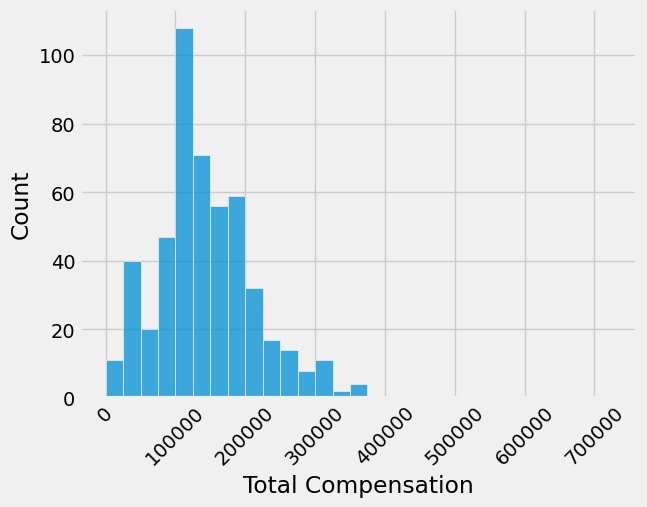

In [14]:
sns.histplot(resample_1['Total Compensation'], bins=sf_bins);
plt.xticks(rotation=45);

In [15]:
resampled_median_1 = np.percentile(resample_1['Total Compensation'], 50, method='nearest')
resampled_median_1

133252.0

Este valor é uma estimativa da mediana da população.

Reamostrando repetidamente, podemos obter muitas dessas estimativas e, portanto, uma distribuição empírica das estimativas.

In [17]:
resample_2 = our_sample.sample(replace=True, n=500)
resampled_median_2 = np.percentile(resample_2['Total Compensation'], 50, method='nearest')
resampled_median_2

136695.0

Vamos coletar esse código e definir uma função `one_bootstrap_median` que retorna uma média inicializada de compensação total, com base na inicialização da amostra aleatória original que chamamos de `our_sample`.

In [18]:
def one_bootstrap_median():
    resampled_table = our_sample.sample(replace=True, n=500)
    bootstrapped_median = np.percentile(resampled_table['Total Compensation'], 50, method='nearest')
    return bootstrapped_median

Execute a célula abaixo algumas vezes para ver como as medianas de bootstrap variam. Lembre-se de que cada um deles é uma estimativa da mediana da população.

In [19]:
one_bootstrap_median()

139182.0

## Distribuição Empírica Bootstrap da Mediana de Amostra

Agora podemos repetir o processo de bootstrap várias vezes executando um loop `for` como de costume. Em cada iteração, chamaremos a função `one_bootstrap_median` para gerar um valor da mediana inicializada com base em nossa amostra original `our_sample`. Em seguida, anexaremos a mediana boostrap ao array de coleta `bstrap_medians`.

Como estamos solicitando 5.000 repetições, o código pode demorar um pouco para ser executado. Tem muito reamostragem para fazer!

In [20]:
num_repetitions = 5000
bstrap_medians = np.array([])
for i in np.arange(num_repetitions):
    bstrap_medians = np.append (bstrap_medians, one_bootstrap_median())

Aqui está um histograma empírico das 5000 medianas bootstrap. O ponto verde é o parâmetro populacional: é a mediana de toda a população, que é o que estamos tentando estimar. Neste exemplo, sabemos o seu valor, mas não o usamos no processo de bootstrap.

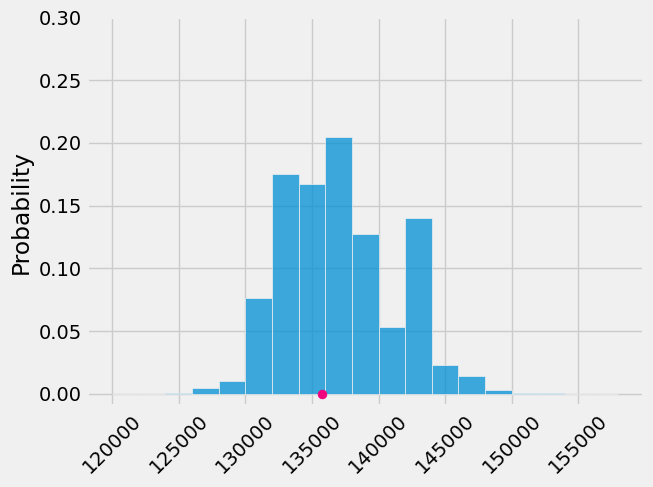

In [25]:
median_bins=np.arange(120000, 160000, 2000)
sns.histplot(bstrap_medians, bins=median_bins, stat='probability');
plt.xticks(rotation=45);

# Plotting parameters; you can ignore this code
parameter_red = '#F0027F'
plt.ylim(-0.01, 0.3)
plt.scatter(pop_median, 0, color=parameter_red, s=40, zorder=2);

É importante lembrar que o ponto vermelho é fixo: são 135.747 dólares, a mediana da população. O histograma empírico é o resultado de sorteios aleatórios, e será situado aleatoriamente em relação ao ponto verde.

Lembre-se também de que o objetivo de todos esses cálculos é estimar a mediana da população, que é o ponto vermelho. Nossas estimativas são todas as medianas amostradas geradas aleatoriamente cujo histograma você vê acima. Queremos que o conjunto dessas estimativas contenha o parâmetro. Se não, então as estimativas estão erradas.

## As estimativas capturam o parâmetro?

Com que frequência o histograma empírico das medianas reamostradas fica firme sobre o ponto vermelho, e não apenas fique o ponto com suas caudas ou não o cobre de forma alguma? Para responder a isso, devemos definir "sentar com firmeza". Vamos entender que "os 95% intermediários das medianas reamostradas contêm o ponto verde".

Aqui estão as duas extremidades do intervalo "meio 95%" das medianas reamostradas:

In [26]:
left = np.percentile(bstrap_medians, 2.5)
left

130473.0

In [27]:
right = np.percentile(bstrap_medians, 97.5)
right

145419.0

A mediana da população de 135.747 dólares está entre esses dois números. O intervalo e a mediana da população são mostrados no histograma abaixo.

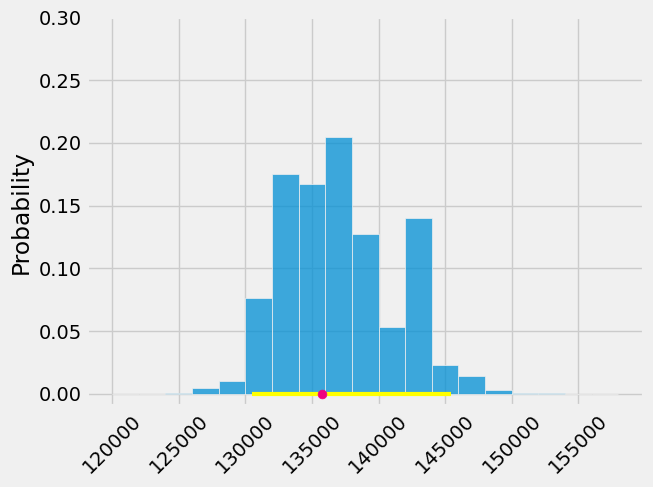

In [28]:
median_bins=np.arange(120000, 160000, 2000)
sns.histplot(bstrap_medians, bins=median_bins, stat='probability')
plt.xticks(rotation=45);

# Plotting parameters; you can ignore this code
parameter_red = '#F0027F'
plt.ylim(-0.01, 0.3)
plt.scatter(pop_median, 0, color=parameter_red, s=40, zorder=2)
plt.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1);


O intervalo de estimativas "95% médio" capturou o parâmetro em nosso exemplo. Mas isso foi um acaso?

Para ver com que frequência o intervalo contém o parâmetro, temos que executar todo o processo repetidamente. Especificamente, replicaremos o seguinte processo 100 vezes:

- Desenhe uma amostra aleatória original de tamanho 500 da população.
- Realizar 5000 replicações do processo bootstrap e gerar o intervalo "meio 95%" das medianas reamostradas.

Terminaremos com 100 intervalos e contaremos quantos deles contêm a mediana da população.

**Alerta de spoiler:** A teoria estatística do bootstrap diz que o número deve estar em torno de 95. Pode estar no intervalo (90,  99), mas não esperamos que esteja muito mais longe de 95 do que isso.

We will start by writing a function `bootstrap_median` that takes two arguments: the name of the table containing the original random sample, and the number of bootstrap samples to draw. It returns an array of bootstrapped medians, one from each boostrap sample.

In [29]:
def bootstrap_median(original_sample, num_repetitions):
    medians = np.array([])
    for i in np.arange(num_repetitions):
        new_bstrap_sample = original_sample.sample(replace=True, n=len(original_sample))
        new_bstrap_median = np.percentile(new_bstrap_sample['Total Compensation'], 
                                          50, method='nearest')
        medians = np.append(medians, new_bstrap_median)
    return medians

Agora, escreveremos um loop `for` que chama essa função 100 vezes e coleta os "95% do meio" das medianas de inicialização a cada vez.

A célula abaixo levará vários minutos para ser executada, pois tem que executar 100 replicações de amostragem 500 vezes aleatoriamente da tabela e gerar 5.000 amostras de bootstrap.

In [30]:
# THE BIG SIMULATION: This one takes several minutes.

# Generate 100 intervals and put the endpoints in the table intervals

left_ends = np.array([])    
right_ends = np.array([])
for i in np.arange(100):
    original_sample = sf2019.sample(500, replace=False)
    medians = bootstrap_median(original_sample, 5000)
    left_ends = np.append(left_ends, np.percentile(medians, 2.5, method='nearest'))
    right_ends = np.append(right_ends, np.percentile(medians, 97.5, method='nearest' ))

intervals = pd.DataFrame().assign(Left=left_ends, Right=right_ends)
   

Para cada uma das 100 repetições de todo o processo, obtemos um intervalo de estimativas da mediana.

In [31]:
intervals

,Left,Right
0,130499.0,142250.0
1,130329.0,143098.0
2,136021.0,151120.0
3,129814.0,144209.0
4,123675.0,139578.0
...,...,...
95,135177.0,148223.0
96,123974.0,139895.0
97,128735.0,144292.0
98,129622.0,143623.0


Os intervalos bons são aqueles que contêm o parâmetro que estamos tentando estimar. Normalmente, o parâmetro é desconhecido, mas nesta seção sabemos qual é o parâmetro.

In [32]:
pop_median

135747.0

Quantos dos 100 intervalos contêm a mediana da população? Esse é o número de intervalos em que a extremidade esquerda está abaixo da mediana da população e a extremidade direita está acima.

In [71]:
intervals[(intervals['Left'] < pop_median) & (intervals['Right'] > pop_median)].shape

(95, 2)

Leva muitos minutos para construir todos os intervalos, mas tente novamente se tiver paciência. Provavelmente, cerca de 95 dos 100 intervalos serão bons: eles conterão o parâmetro.

É difícil mostrar todos os intervalos no eixo horizontal, pois eles têm grandes sobreposições – afinal, todos estão tentando estimar o mesmo parâmetro. O gráfico abaixo mostra cada intervalo nos mesmos eixos empilhando-os verticalmente. O eixo vertical é simplesmente o número da replicação a partir da qual o intervalo foi gerado.

A linha verde é onde está o parâmetro. Tem uma posição fixa, pois o parâmetro é fixo.

Bons intervalos cobrem o parâmetro. Existem aproximadamente 95 destes, normalmente.

Se um intervalo não cobre o parâmetro, é um fracasso. Os insucessos são aqueles onde você pode ver a "luz do dia" ao redor da linha verde. Existem muito poucos deles – cerca de 5 em 100, normalmente – mas eles acontecem.

Qualquer método baseado em amostragem tem a possibilidade de estar errado. A beleza dos métodos baseados em amostragem aleatória é que podemos quantificar com que frequência eles provavelmente estarão errados.

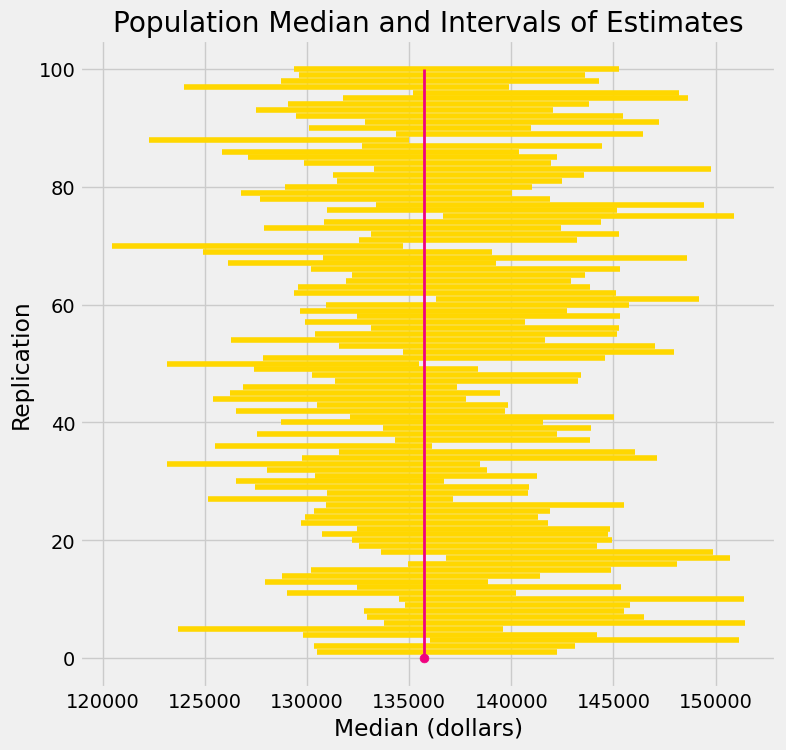

In [33]:
replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals2 = pd.DataFrame(index=replication_number).assign(Left=left_ends, Right=right_ends)

plt.figure(figsize=(8,8))
for i in np.arange(100):
    ends = intervals2.iloc[i]
    plt.plot(ends, np.array([i+1, i+1]), color='gold')
plt.scatter(pop_median, 0, color=parameter_red, s=40, zorder=2)
plt.plot(np.array([pop_median, pop_median]), np.array([0, 100]), color=parameter_red, lw=2)
plt.xlabel('Median (dollars)')
plt.ylabel('Replication')
plt.title('Population Median and Intervals of Estimates');

Para resumir o que a simulação mostra, suponha que você esteja estimando a mediana da população pelo seguinte processo:

- Retirar uma grande amostra aleatória da população.
- Bootstrap sua amostra aleatória e obtenha uma estimativa da nova amostra aleatória.
- Repita a etapa de bootstrap acima milhares de vezes e obtenha milhares de estimativas.
- Escolha o intervalo "meio 95%" de todas as estimativas.

Isso lhe dá um intervalo de estimativas. Se 99 outras pessoas repetirem **todo o processo**, começando com uma nova amostra aleatória a cada vez, você terminará com 100 desses intervalos. Cerca de 95 desses 100 intervalos conterão o parâmetro populacional.

Em outras palavras, esse processo de estimação captura o parâmetro cerca de 95% das vezes.

Você pode substituir 95% por um valor diferente, desde que não seja 100. Suponha que você substitua 95% por 80% e mantenha o tamanho da amostra fixo em 500. Então seus intervalos de estimativas serão menores do que os que simulamos aqui, porque o "80% do meio" é um intervalo menor do que "95% do meio". Se você continuar repetindo esse processo, apenas cerca de 80% dos seus intervalos conterão o parâmetro.